In [1]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import scipy as sci
from sklearn.cluster import KMeans


# Utils

In [2]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """  
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    Degrees=np.diag(np.sum(adjacency,1))
    #print(  (np.sum(adjacency,1) == 0).any()   )
    if normalize==False:
        L=Degrees-adjacency
    if normalize==True:
        D_norm=np.diag(np.sum(adjacency,1)**(-1/2))
        L=D_norm@(Degrees-adjacency)@D_norm
    return L

def spectral_decomposition(laplacian: np.ndarray):
    lamb, U=sci.linalg.eigh(laplacian)
    sorted_idx = np.argsort(lamb)
    lamb = lamb[sorted_idx]
    U=U[:,sorted_idx]
    return lamb,U


def GFT(signal, U):
    # Your code here
    print(len(signal))
    return U.T @ signal

def iGFT(fourier_coefficients, U):
    # Your code here
    return U @ fourier_coefficients
def ideal_graph_filter(x, spectral_response, U):
    """Return a filtered signal."""
    # Your code here
    # spectral_response is in the fourier domain
    # x is in the graph domain
    # need to converge x to the fourier domain 
    # finally convert all back to the graph domain
    return iGFT(GFT(x,U) * spectral_response, U)

# Prepare data

In [3]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

In [4]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

# keep only summury information of each county
df_migrations = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration")]

# create the combined fips county number 
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# drop useless information 
df_migrations = df_migrations.drop(columns=["y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str"])

# seperate each possible migration into three dataframe 
df_migration_total = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US and Foreign")]
df_migrations['y1_countyname'] = df_migrations['y1_countyname'].apply(lambda x : x if x.find("County Total Migration-US and Foreign") == -1 else "County Total Migration Both")
df_migration_us = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US")]
df_migration_for = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-Foreign")]

# drop the name of the column 
df_migration_total = df_migration_total.drop(columns=["y1_countyname"])
df_migration_us = df_migration_us.drop(columns=["y1_countyname"])
df_migration_for = df_migration_for.drop(columns=["y1_countyname"])

# remove nodes where data is undefined undefined data by zero
df_migration_total = df_migration_total[df_migration_total['n1'] != -1]
df_migration_us = df_migration_us[df_migration_us['n1'] != -1]
df_migration_for = df_migration_for[df_migration_for['n1'] != -1]

# convert combined fips to int64
df_migration_total['combined_fips'] = df_migration_total['combined_fips'].astype('int64')
df_migration_us['combined_fips'] = df_migration_us['combined_fips'].astype('int64')
df_migration_for['combined_fips'] = df_migration_for['combined_fips'].astype('int64')

In [5]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])

In [6]:
# merge the two dataset and drop useless column, add a new column winner 
df_merged_total = pd.merge(df_migration_total, df_presidential_result, on="combined_fips", how='inner')
df_merged_us = pd.merge(df_migration_us, df_presidential_result, on="combined_fips", how='inner')
df_merged_for = pd.merge(df_migration_for, df_presidential_result, on="combined_fips", how='inner')
df_merged_total['difference'] = df_merged_total['per_dem'] - df_merged_total['per_gop']
df_merged_us['difference'] = df_merged_us['per_dem'] - df_merged_total['per_gop']
df_merged_for['difference'] = df_merged_for['per_dem'] - df_merged_total['per_gop']
df_merged_total['winner'] = df_merged_total['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_us['winner'] = df_merged_us['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_for['winner'] = df_merged_for['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_total = df_merged_total.drop(columns=['difference'])
df_merged_us = df_merged_us.drop(columns=['difference'])
df_merged_for = df_merged_for.drop(columns=['difference'])

# Compute Adjacency matrix

0.5284353963018223


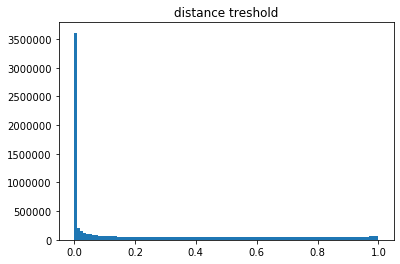

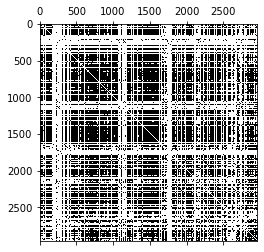

In [7]:
X_total = df_merged_total.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_total = df_merged_total.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_total['agi'] = (X_total['agi'] - X_total['agi'].mean()) / X_total['agi'].std()
X_total['prop_ret/exempt'] = X_total['n1'] / X_total['n2']
X_total = X_total.drop(columns=['n1', 'n2'])
adjacency_RGB_total = epsilon_similarity_graph(X_total, sigma=0.5284353963018223*0.1, epsilon=0.2)
plt.spy(adjacency_RGB_total)
plt.show()

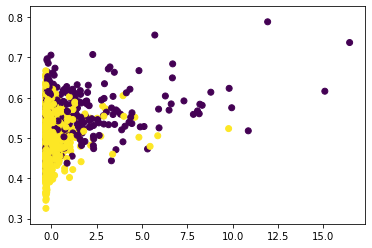

In [8]:
plt.scatter(X_total["agi"], X_total["prop_ret/exempt"], c=df_merged_total["winner"])
plt.show()

# signal => gft => lp => igft => adjacency and neighbour => threshold

### Division by zero in normalized lapacien computation

- some nodes do not have any connection in the graph => create new adjacency matrix A by deleting these nodes

# Randomly choose some points for prediction use

In [9]:
def pred_iteration(A,iters, x, n, filtered_x_lp):
    accurary =[]
    for i in iters:
        test_idx = np.random.choice(np.arange(len(x)),n,replace = False)
        # masking some winner
        x[test_idx]=0
        #prepare ground truth
        truth = (df_merged_total["winner"][test_idx]).values

        pred = []
        for i in test_idx:
            l = np.where(A[i] !=0)[0]  # searching neigbhours
            tmp = 0
            for j in l:
                
                tmp += filtered_x_lp[j]
            pred.append(tmp/len(l))   # compute mean
        # thresholding
        pred_thres = np.array(pred)
        pred_thres [pred_thres >0 ] = 1
        pred_thres [pred_thres <0 ] = -1

        # ground truth
        truth = (df_merged_total["winner"][test_idx]).values

        right_pred = []
        for i in range(len(pred_thres)):
            if(pred_thres[i] == truth[i]):
                right_pred.append(i)
                
        accurary.append( len(right_pred)/len(test_idx))
        
    mean = np.mean(accurary)
    var = np.std(accurary)
    print("The mean is ",mean)
    print("The variance is ",var)
    return mean,var

In [10]:
# prepare A and x(signal)
A = adjacency_RGB_total.copy()
rows_to_be_deleted = np.where(np.sum(adjacency_RGB_total,1) == 0)
A = np.delete(A, rows_to_be_deleted,0)
A = np.delete(A, rows_to_be_deleted,1)
x = df_merged_total["winner"]
x = np.delete(np.array(x), rows_to_be_deleted,0) 
# compute lamb and U
laplacian = compute_laplacian(A, normalize=True)
lamb, U = spectral_decomposition(laplacian)

In [11]:
# prepare filter
n_nodes = A.shape[0]
ideal_lp = np.ones((n_nodes,)) 
ideal_lp[lamb >= 0.1] = 0   # to tune
# apply filter
x_lp = ideal_graph_filter(x,ideal_lp,U)

2939


In [12]:
iters = np.arange(10)
n = int(len(x)*0.2)

In [13]:
accuracy_mean, accuracy_var = pred_iteration(A,iters, x, n, x_lp)

The mean is  0.828449744463373
The variance is  0.018205975942647584


# Questions:
- algo: why low pass; [0,1,-1,1,0] => iGFT(GFT*lp) =>  [_,?,?,?,_]
- plot with lamb ?
- good graph ?  => `agi` and `exemplt` can predict the winner at 82%
- satisfactory result ?

# FOR

0.6675252605174868


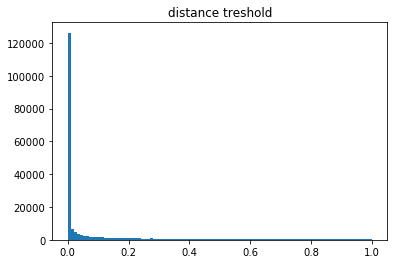

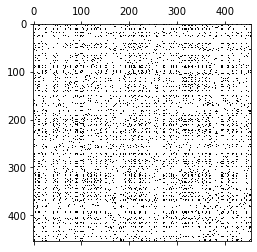

In [12]:
X_for = df_merged_for.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_for = df_merged_for.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_for['agi'] = (X_for['agi'] - X_for['agi'].mean()) / X_for['agi'].std()
X_for['prop_ret/exempt'] = X_for['n1'] / X_for['n2']
X_for = X_for.drop(columns=['n1', 'n2'])
adjacency_RGB_for = epsilon_similarity_graph(X_for, sigma=0.6675252605174871*0.1, epsilon=0.5)
plt.spy(adjacency_RGB_for)
plt.show()

In [18]:
# prepare A and x(signal)
A_for = adjacency_RGB_for.copy()
rows_to_be_deleted_for = np.where(np.sum(adjacency_RGB_for,1) == 0)
A_for = np.delete(A_for, rows_to_be_deleted_for,0)
A_for = np.delete(A_for, rows_to_be_deleted_for,1)
x_for = df_merged_for["winner"]
x_for = np.delete(np.array(x_for), rows_to_be_deleted_for,0) 
# compute lamb and U
laplacian_for = compute_laplacian(A_for, normalize=True)
lamb_for, U_for = spectral_decomposition(laplacian_for)

In [19]:
# prepare filter
ideal_lp_for = np.ones((A_for.shape[0],)) 
ideal_lp_for[lamb_for >= 0.1] = 0   # to tune
# apply filter
x_lp_for = ideal_graph_filter(x_for,ideal_lp_for,U_for)

437


In [29]:
iters_for = np.arange(10)
n_for = int(len(x_for)*0.2)

In [35]:
accuracy_mean_for, accuracy_var_for = pred_iteration(A_for,iters_for, x_for, n_for, x_lp_for)

The mean is  0.7195402298850574
The variance is  0.03784385662794099


(0.7195402298850574, 0.03784385662794099)

# US

0.5310405705207334


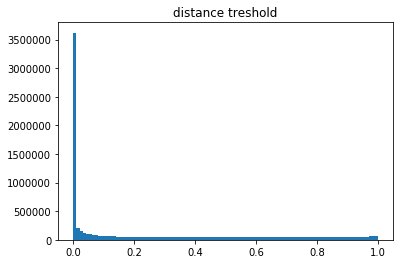

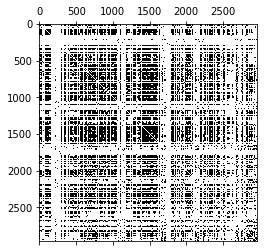

In [36]:
X_us = df_merged_us.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_us = df_merged_us.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_us['agi'] = (X_us['agi'] - X_us['agi'].mean()) / X_us['agi'].std()
X_us['prop_ret/exempt'] = X_us['n1'] / X_us['n2']
X_us = X_us.drop(columns=['n1', 'n2'])
adjacency_RGB_us = epsilon_similarity_graph(X_us, sigma=0.5310405705207334*0.1, epsilon=0.5)
plt.spy(adjacency_RGB_us)
plt.show()

In [37]:
# prepare A and x(signal)
A_us = adjacency_RGB_us.copy()
rows_to_be_deleted_us = np.where(np.sum(adjacency_RGB_us,1) == 0)
A_us = np.delete(A_us, rows_to_be_deleted_us,0)
A_us = np.delete(A_us, rows_to_be_deleted_us,1)
x_us = df_merged_us["winner"]
x_us = np.delete(np.array(x_us), rows_to_be_deleted_us,0) 
# compute lamb and U
laplacian_us = compute_laplacian(A_us, normalize=True)
lamb_us, U_us = spectral_decomposition(laplacian_us)

In [38]:
# prepare filter
ideal_lp_us = np.ones((A_us.shape[0],)) 
ideal_lp_us[lamb_us >= 0.1] = 0   # to tune
# apply filter
x_lp_us = ideal_graph_filter(x_us,ideal_lp_us,U_us)

2921


In [39]:
iters_us = np.arange(10)
n_us = int(len(x_for)*0.2)

In [41]:
accuracy_mean_us, accuracy_var_us = pred_iteration(A_us,iters_us, x_us, n_us, x_lp_us)

The mean is  0.8195402298850574
The variance is  0.03293459490090667


(0.8195402298850574, 0.03293459490090667)

# GCN

In [14]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

In [15]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [16]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

0.6675252605174868


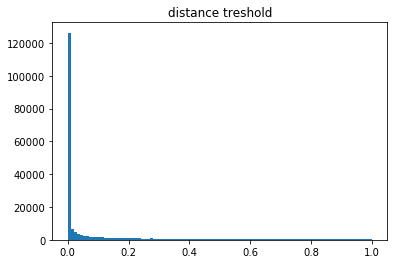

In [101]:
X_for = df_merged_for.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_for = df_merged_for.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
X_for['agi'] = (X_for['agi'] - X_for['agi'].mean()) / X_for['agi'].std()
X_for['prop_ret/exempt'] = X_for['n1'] / X_for['n2']
X_for = X_for.drop(columns=['n1', 'n2'])
adjacency_RGB_for = epsilon_similarity_graph(X_for, sigma=0.6675252605174871*0.1, epsilon=0.5)

# prepare A and x(signal)
A_for = adjacency_RGB_for.copy()
rows_to_be_deleted_for = np.where(np.sum(adjacency_RGB_for,1) == 0)
A_for = np.delete(A_for, rows_to_be_deleted_for,0)
A_for = np.delete(A_for, rows_to_be_deleted_for,1)
y_for = df_merged_for["winner"]
y_for = np.delete(np.array(y_for), rows_to_be_deleted_for,0) 

X_for = X_for.values
X_for = np.delete(np.array(X_for), rows_to_be_deleted_for,0) 

# compute lamb and U
laplacian_for = compute_laplacian(A_for, normalize=True)
lamb_for, U_for = spectral_decomposition(laplacian_for)

In [102]:
# Some basic settings
features = torch.FloatTensor(X_for) # Feature vector for node
labels = torch.LongTensor(y_for) 

in_feats = features.shape[1]  # 2
n_classes = 2
n_edges = int(A_for.sum() // 2)
#print(in_feats,n_classes,n_edges)

In [142]:
# prepare for masking
n_points = X_for.shape[0]
indices = np.arange(n_points)
np.random.shuffle(indices)
split_t = int(n_points*0.1)
split_v = int(n_points*0.3)
test_idx = indices[:split_t]
val_idx = indices[split_t:split_v]
train_idx = indices[split_v:]

train_mask = np.zeros(n_points)
train_mask[train_idx] = 1
val_mask = np.zeros(n_points)
val_mask[val_idx] = 1
test_mask = np.zeros(n_points)
test_mask[test_idx] = 1

In [131]:
graph = nx.from_numpy_matrix(A_for)
adjacency = np.asarray(nx.to_numpy_matrix(graph))
n_nodes = adjacency.shape[0]
lam_max = np.max(lamb_for)

pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 500
p_dropout = 0.8

In [143]:
graph = DGLGraph(graph)
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/home/xzou/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/xzou/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 0.6931 | Val Accuracy 0.7986
Epoch 00001 | Time(s) nan | Train Loss 0.6380 | Val Accuracy 0.2014
Epoch 00002 | Time(s) nan | Train Loss 0.5184 | Val Accuracy 0.2014
Epoch 00003 | Time(s) 0.0150 | Train Loss 2.4698 | Val Accuracy 0.2014
Epoch 00004 | Time(s) 0.0099 | Train Loss 1.7695 | Val Accuracy 1.0000
Epoch 00005 | Time(s) 0.0093 | Train Loss 0.5967 | Val Accuracy 1.0000
Epoch 00006 | Time(s) 0.0090 | Train Loss 0.6448 | Val Accuracy 0.2014
Epoch 00007 | Time(s) 0.0082 | Train Loss 0.6697 | Val Accuracy 0.2014
Epoch 00008 | Time(s) 0.0076 | Train Loss 0.6848 | Val Accuracy 0.0000
Epoch 00009 | Time(s) 0.0072 | Train Loss 0.7308 | Val Accuracy 0.0000
Epoch 00010 | Time(s) 0.0068 | Train Loss 0.8089 | Val Accuracy 0.0000
Epoch 00011 | Time(s) 0.0066 | Train Loss 0.6772 | Val Accuracy 0.0000
Epoch 00012 | Time(s) 0.0064 | Train Loss 0.6966 | Val Accuracy 0.0000
Epoch 00013 | Time(s) 0.0062 | Train Loss 0.6501 | Val Accuracy 0.7986
Epoch 00014 | T

Epoch 00124 | Time(s) 0.0065 | Train Loss 0.0054 | Val Accuracy 1.0000
Epoch 00125 | Time(s) 0.0065 | Train Loss 0.0003 | Val Accuracy 1.0000
Epoch 00126 | Time(s) 0.0065 | Train Loss 0.0002 | Val Accuracy 1.0000
Epoch 00127 | Time(s) 0.0064 | Train Loss 0.1655 | Val Accuracy 1.0000
Epoch 00128 | Time(s) 0.0064 | Train Loss 0.0029 | Val Accuracy 1.0000
Epoch 00129 | Time(s) 0.0064 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00130 | Time(s) 0.0064 | Train Loss 0.0182 | Val Accuracy 1.0000
Epoch 00131 | Time(s) 0.0064 | Train Loss 0.0006 | Val Accuracy 1.0000
Epoch 00132 | Time(s) 0.0064 | Train Loss 0.0377 | Val Accuracy 1.0000
Epoch 00133 | Time(s) 0.0065 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00134 | Time(s) 0.0064 | Train Loss 0.0001 | Val Accuracy 1.0000
Epoch 00135 | Time(s) 0.0065 | Train Loss 0.0116 | Val Accuracy 1.0000
Epoch 00136 | Time(s) 0.0064 | Train Loss 0.0010 | Val Accuracy 1.0000
Epoch 00137 | Time(s) 0.0064 | Train Loss 0.0008 | Val Accuracy 1.0000
Epoch 

Epoch 00256 | Time(s) 0.0068 | Train Loss 0.0005 | Val Accuracy 1.0000
Epoch 00257 | Time(s) 0.0068 | Train Loss 0.0001 | Val Accuracy 1.0000
Epoch 00258 | Time(s) 0.0068 | Train Loss 0.0008 | Val Accuracy 1.0000
Epoch 00259 | Time(s) 0.0068 | Train Loss 0.0005 | Val Accuracy 1.0000
Epoch 00260 | Time(s) 0.0068 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00261 | Time(s) 0.0068 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00262 | Time(s) 0.0068 | Train Loss 0.0003 | Val Accuracy 1.0000
Epoch 00263 | Time(s) 0.0068 | Train Loss 0.0005 | Val Accuracy 1.0000
Epoch 00264 | Time(s) 0.0068 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00265 | Time(s) 0.0068 | Train Loss 0.0001 | Val Accuracy 1.0000
Epoch 00266 | Time(s) 0.0068 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00267 | Time(s) 0.0068 | Train Loss 0.0051 | Val Accuracy 1.0000
Epoch 00268 | Time(s) 0.0068 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00269 | Time(s) 0.0068 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 

Epoch 00375 | Time(s) 0.0063 | Train Loss 0.0002 | Val Accuracy 1.0000
Epoch 00376 | Time(s) 0.0063 | Train Loss 0.0001 | Val Accuracy 1.0000
Epoch 00377 | Time(s) 0.0063 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00378 | Time(s) 0.0063 | Train Loss 0.0001 | Val Accuracy 1.0000
Epoch 00379 | Time(s) 0.0063 | Train Loss 0.0002 | Val Accuracy 1.0000
Epoch 00380 | Time(s) 0.0063 | Train Loss 0.0036 | Val Accuracy 1.0000
Epoch 00381 | Time(s) 0.0063 | Train Loss 0.0001 | Val Accuracy 1.0000
Epoch 00382 | Time(s) 0.0063 | Train Loss 0.0004 | Val Accuracy 1.0000
Epoch 00383 | Time(s) 0.0063 | Train Loss 0.0006 | Val Accuracy 1.0000
Epoch 00384 | Time(s) 0.0063 | Train Loss 0.0005 | Val Accuracy 1.0000
Epoch 00385 | Time(s) 0.0063 | Train Loss 0.0008 | Val Accuracy 1.0000
Epoch 00386 | Time(s) 0.0063 | Train Loss 0.0004 | Val Accuracy 1.0000
Epoch 00387 | Time(s) 0.0063 | Train Loss 0.0000 | Val Accuracy 1.0000
Epoch 00388 | Time(s) 0.0063 | Train Loss 0.0012 | Val Accuracy 1.0000
Epoch 

Epoch 00498 | Time(s) 0.0061 | Train Loss 0.0004 | Val Accuracy 1.0000
Epoch 00499 | Time(s) 0.0061 | Train Loss 0.0001 | Val Accuracy 1.0000

Test Accuracy 1.0000


In [144]:
coeff_gcn =  model.pol_weights.detach().numpy()
print(coeff_gcn)

[-4.71316    3.9751382  0.871704  -1.0368031]


In [134]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    res = np.zeros((len(coeff),len(lam)))
    for i in range(len(coeff)):
        res[i] = coeff[i] * (lam**i)
    res = np.sum(res,axis =0)
    return res

Text(0, 0.5, 'Spectral response (db)')

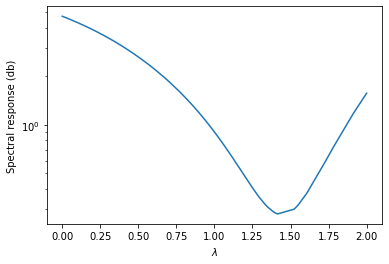

In [145]:
plt.semilogy(lamb_for, np.abs(polynomial_graph_filter_response(coeff_gcn, lamb_for)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)') # ------------

In [136]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    # Your code here
    res = np.zeros_like(laplacian)
    for i in range (len(coeff)):
        res += coeff[i] * np.linalg.matrix_power(laplacian, i)
    return res

In [137]:
graph_gcn_filter = polynomial_graph_filter(coeff_gcn, laplacian_for)

In [138]:
len(graph_gcn_filter)

437

In [146]:
features_gcn = graph_gcn_filter @ features.numpy()

train_mask = torch.BoolTensor(train_mask) 
val_mask = torch.BoolTensor(val_mask)  
test_mask = torch.BoolTensor(test_mask)

train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

In [140]:
model3 =  LogisticRegression(C=1000,penalty = 'l2',solver='liblinear', multi_class='auto',max_iter = 2000)
model3.fit(train_features_gcn, train_labels)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [165]:
train_acc = model3.score(train_features_gcn,train_labels)
val_acc =  model3.score(val_features_gcn,val_labels)
test_acc =  model3.score(test_features_gcn,test_labels)  

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.6863 | Validation accuracy 0.7955 | Test accuracy 0.7907
